# EDA Skeleton
<hr>

Use this to load our data into a dataframe and perform any exploration you like.

In [56]:
from collections import Counter
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
pd.options.mode.chained_assignment = None
from sqlalchemy import create_engine
from pandas.io import sql
import pickle
from os import path
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image



# Database creds, don't share on public repo
hostname='95.217.156.58'
dbname='crimeStats'
uname='sandwich'
pwd='321#@!IdiotSandwich'
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd))

# pulls clean data from repo and saves locally
if path.exists("crime.dat"):
    print("Found crime data. Loading as pandas df")
    fh = open("crime.dat", 'rb')
    df = pickle.load(fh)
    fh.close()
else:
    print("Crime data not downloaded, saving file in root dir as crime.dat")
    print("Downloading 1.2GB, this may take a while...")
    df = pd.read_sql('SELECT * FROM crimeTable', con=engine)
    fh = open('crime.dat', 'wb+')
    pickle.dump(df, fh)
    fh.close()

Found crime data. Loading as pandas df


In [57]:
df

,arrest_key,arrest_date,pd_desc,ofns_desc,law_code,law_cat_cd,age_group,perp_sex,perp_race,latitude,longitude,arrest_boro,arrest_precinct,jurisdiction_code,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih
0,192799737,2019-01-26,SEXUAL ABUSE,SEX CRIMES,PL 1306503,F,45-64,M,BLACK,40.800694,-73.941109,M,25,0.0,7.0,4.0,36.0,16.0
1,193260691,2019-02-06,CRIMINAL SALE OF A CONTROLLED SUBSTANCE,CONTROLLED SUBSTANCES OFFENSES,PL 2203400,F,25-44,M,UNKNOWN,40.757839,-73.991212,M,14,0.0,12.0,4.0,10.0,8.0
2,149117452,2016-01-06,RAPE 3,RAPE,PL 1302503,F,25-44,M,BLACK,40.648650,-73.950336,K,67,0.0,61.0,2.0,11.0,40.0
3,190049060,2018-11-15,RAPE 1,RAPE,PL 1303501,F,25-44,M,BLACK,40.674583,-73.930222,K,77,0.0,16.0,2.0,49.0,49.0
4,24288194,2006-09-13,"TRESPASS 3, CRIMINAL",CRIMINAL TRESPASS,PL 140100E,M,45-64,M,BLACK,40.671254,-73.926714,K,77,2.0,16.0,2.0,49.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881984,24592084,2006-10-01,"LARCENY,GRAND FROM OPEN AREAS,UNCLASSIFIED",GRAND LARCENY,PL 1553001,F,<18,M,BLACK,40.676655,-73.916466,K,73,0.0,69.0,2.0,17.0,52.0
3881985,24028282,2006-08-25,"MARIJUANA, SALE 4 & 5",DANGEROUS DRUGS,PL 2214000,M,<18,M,WHITE,40.625264,-73.998697,K,62,0.0,10.0,2.0,7.0,41.0
3881986,24036787,2006-08-26,"PUBLIC ADMINISTATION,UNCLASS MISDEMEAN 4",OFFENSES AGAINST PUBLIC ADMINISTRATION,PL 1950500,M,18-24,M,BLACK,40.801304,-73.936106,M,25,0.0,7.0,4.0,35.0,16.0
3881987,24028407,2006-08-25,"TRAFFIC,UNCLASSIFIED MISDEMEANOR",VEHICLE AND TRAFFIC LAWS,VTL05110E2,F,25-44,M,BLACK,40.675505,-73.899692,K,75,0.0,45.0,2.0,37.0,47.0


# Which Law code is famous in violation? 

We're not going to focus on EXACT law code like ```PL 1306503``` or ```VTL05110E2``` but instead we're focusing on overall law_code, that is common PL or VTL or something else?

In [64]:
# Let's work on a copy of dataset and not the original one.
df1=df[['arrest_key','law_code']]

# All law_code have length of 10, but we care about the first 2-3 letters.
# So let's get length on code and then, remove the unecessary numbers or letters.
df1['len']=df1['law_code'].apply(lambda x: len(x))

df1.len.unique()

array([10,  8,  2])

In [65]:
# Function to return only first 2-3 letters which represent law_code category.
def codes(x):
    if len(x) == 10:
        return x[:-7]
    if len(x) == 8:
        return x[:-6]
    else:
        return x

In [74]:
# Run the function for all records
df1['code']=df1['law_code'].apply(lambda x: codes(x))

# remove the whitespace
df1['code_len']=df1['code'].apply(lambda x: len(x.strip()))

count=df1.groupby('code')['arrest_key'].count().nlargest(5)
count

code
PL     3215636
VTL     386337
LOC     221704
FOA      13369
TAX      12833
Name: arrest_key, dtype: int64

In [78]:
codes,code_count=[],[]
for i,j in dict(count).items():
    codes.append(i)
    code_count.append(j)

In [80]:
fig = px.bar(x=codes, y=code_count,
            text=count)

fig.update_layout(
    title='Top 5 law codes that were violted in the past 14 years',
    xaxis_title="Law Code",
    yaxis_title="# of Cases")

fig.show()


In [82]:
len(df1.code.unique())

41

#### Conclusion
There are total of **41** unique law codes, but top 5 are PL, VTL, LOC, FOA and TAX.
**82.8%** of total crimes in NYC are PL (Penal Law) crime cases.

<hr>

# Which Year was peak in the crime?

In [89]:
df1=df[['arrest_key','arrest_date']]

In [90]:
df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year

In [91]:
uni_years=sorted(df1['arrest_year'].unique())
count=df1.groupby('arrest_year')['arrest_year'].count()
fig = px.line(
    x=uni_years,
    y=count,
    title="Number of cases each year")
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Cases that Year")

fig.update_xaxes(tick0=1,dtick=1)

fig.show()

#### Conclusion
Crime Cases peaked in 2011, but it started to decline slowly after that.

We see small rise in 2014, and hard decline after that, which could be because NYC had elected new Mayor Bill De Blasio and the newly Mayor also chose Bill Bratton as the new Police Commissioner. Bill has been named “the city's most significant police leaders of the past quarter-century” by New York Times


<hr>

# Trendline of Top 5 Crimes in past 5 years.

In [106]:
recent_df = df.loc[(df['arrest_date'] >= '2014-12-01')]

def getSeasonData(season,endYear):
    if season == "winter":
        df =  recent_df[((recent_df.arrest_date >= str(endYear-1)+'-12-01') & (recent_df.arrest_date <= str(endYear)+'-02-28'))]
    if season == "spring":
        df =  recent_df[((recent_df.arrest_date >= str(endYear)+'-03-01') & (recent_df.arrest_date <= str(endYear)+'-05-31'))]
    if season == "fall":
        df = recent_df[((recent_df.arrest_date >= str(endYear)+'-09-01') & (recent_df.arrest_date <= str(endYear)+'-11-30'))]
    if season == "summer":
        df = recent_df[((recent_df.arrest_date >= str(endYear)+'-06-01') & (recent_df.arrest_date <= str(endYear)+'-08-31'))]
    return df

In [107]:
seasons = []
x = 2015
for i in range(5):
    seasons.append(getSeasonData('winter',x+i))
    seasons.append(getSeasonData('spring',x+i))
    seasons.append(getSeasonData('summer',x+i))
    seasons.append(getSeasonData('fall',x+i))

j = 0
y = 2014
season = []
crimeAmt = []
for i in seasons:
    if j == 0:
        y = y+1
        season.append("winter " + str(y))
    if j == 1:
        season.append("spring " + str(y))
    if j == 2:
        season.append("summer " + str(y))
    if j == 3:
        season.append("fall " + str(y))
        j= -1
    j=j+1
    
    crimeAmt.append(i.shape[0])

In [112]:
lis=[]

for k in dict(recent_df.groupby('ofns_desc')['arrest_key'].count().nlargest(5)):
    for i in seasons:
        df1 = i[i['ofns_desc'] == k]
        lis.append(df1.shape[0])

drugs=lis[:20]
assault=lis[20:40]
theft=lis[40:60]
state=lis[60:80]
petit=lis[80:]

In [113]:
fig = go.Figure()

j=0
for i in c:
    num=j+20
    fig.add_trace(go.Scatter(x=season, y=lis[j:num],
                             mode='lines+markers',
                             name=i
                            ))
    j+=20
fig.update_layout(title='Top 5 crimes rate in the last five years')
fig.show()

In [114]:
for k in dict(recent_df.groupby('ofns_desc')['arrest_key'].count().nlargest(5)):
    print(k)

DANGEROUS DRUGS
ASSAULT 3 & RELATED OFFENSES
PETIT LARCENY
VEHICLE AND TRAFFIC LAWS
OTHER OFFENSES RELATED TO THEFT


#### Conclusion

In the Last Five Years, the Top 5 crimes were: -
    
    - DANGEROUS DRUGS
    - ASSAULT 3 & RELATED OFFENSES
    - PETIT LARCENY
    - VEHICLE AND TRAFFIC LAWS
    - OTHER OFFENSES RELATED TO THEFT
    
We knew that the crime count has been declining in the past 5-6 years, so all the trend lines of the crime slowly declining makes sense.

<hr>

# Relationship between arrest_boro and amount of crimes each month.

In [118]:
df1=df[['arrest_key','arrest_date','arrest_boro']]

In [119]:
df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year
df1['arrest_month'] = pd.DatetimeIndex(df1['arrest_date']).month

In [120]:
data_y=df1.groupby(['arrest_month','arrest_boro'])['arrest_key'].count()
borough=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
li_data_y=list(data_y)
data_x=sorted(df1['arrest_month'].unique())

f = make_subplots(rows=2, 
                  cols=1,
                  shared_xaxes=False,
                  vertical_spacing=0.15,
                  subplot_titles=('Total Crime','Crimes By Borough'))

total_data_y=df1.groupby(['arrest_month'])['arrest_key'].count()

f.add_bar(name="Total crimes in 5 borough",x=data_x,y=total_data_y,row=1,col=1,text=total_data_y)

f.update_traces(texttemplate='%{text:.2s}', textposition='auto')

for i in range(len(borough)):
    f.add_scatter(name=borough[i],x=data_x,y=data_y[i::5],row=2,col=1)
    
    
f.update_layout(
    xaxis = dict(
        title='Month',
        tickmode = 'linear',
        tick0 =1,
        dtick = 1
    ),
    xaxis2 = dict(
        title='Month',
        tickmode = 'linear',
        tick0 =1,
        dtick = 1
    ),
    yaxis1 = dict(
        title='Total Crimes'
    ),
    yaxis2 = dict(
        title='Total Crimes by Borough',
        tickmode = 'linear',
        tick0 =0,
        dtick = 10000
    ),
    height=850, 
    width=950,
    title_text="Each Month's Total Crime vs Crimes By Borough")

f.show()

### Conclusion

- March seems to be most popular for crime, but we don’t know any particular reason for it.
- December seems to be least popular month for crime, it could be because it’s a holiday season so people are with - their families.
- Staten Island has the least amount of crime throughout the year, it’s pretty steady with very little decline in holiday season. 
- We conclude that Brooklyn contributes with the highest amount of crime. 
- So, we can say that the chance of occurring of a crime is same throughout the year in Staten Island but other boroughs have higher chance of crime occurring in March and less chance of crime occurring in December

<hr>

# Crime in Each Borough 

In [115]:
df1=df[['arrest_key','arrest_date','arrest_boro']]

df1['arrest_boro'].replace(['B', 'K', 'M', 'Q', 'S'],
                           ['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],
                           inplace=True)

df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year

In [116]:
boro_co=list(df1.groupby(['arrest_year','arrest_boro']).count()['arrest_key'])
boro=list(sorted(df1.arrest_boro.unique()))*14
years=list(np.repeat(list(sorted(df1.arrest_year.unique())),5))

In [117]:
fig = px.scatter(x=years, y=boro_co, 
                 animation_frame=years, 
                 animation_group=boro,
                 color=boro,
               size=boro_co,
               range_x=[min(years)-1,max(years)+1],
               range_y=[6000,95000]
                )

fig.update_layout(
    title_text='Borough Crime throughout the years',
    xaxis_title="Years",
    yaxis_title="Cases")
fig.update_xaxes(tick0=1,dtick=1)

fig.show()

# CDF for Each Borough

In [21]:
df1=df[['arrest_key','arrest_date','arrest_boro']]

df1['arrest_boro'].replace(['B', 'K', 'M', 'Q', 'S'],
                           ['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],
                           inplace=True)

In [22]:
boros=list(sorted(df1.arrest_boro.unique()))
fig = go.Figure()

for i in boros:
    boro_group=df1[df1['arrest_boro']==i]
    sd=list(boro_group.groupby('arrest_date').count()['arrest_key'])
    monx=np.sort(sd)
    mony=np.arange(1,len(monx)+1)/len(monx)

    fig.add_trace(go.Scatter(x=monx, y=mony,
                    mode='markers',
                    name=i))

fig.update_layout(
    title='Crime: Borough vs Boroughs',
    xaxis_title="Number of crimes per day",
    yaxis_title="Cummulative Probability")

fig.show()

# Word Cloud

In [23]:
long_text = " ".join(word for word in df.ofns_desc)
print ("There are {} words in the ofns_desc attribute.".format(len(long_text)))
stopwords = set(STOPWORDS)

There are 85574474 words in the ofns_desc attribute.


In [24]:
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='white',
    max_words=100,
    stopwords = stopwords,
    min_font_size = 10).generate(long_text)

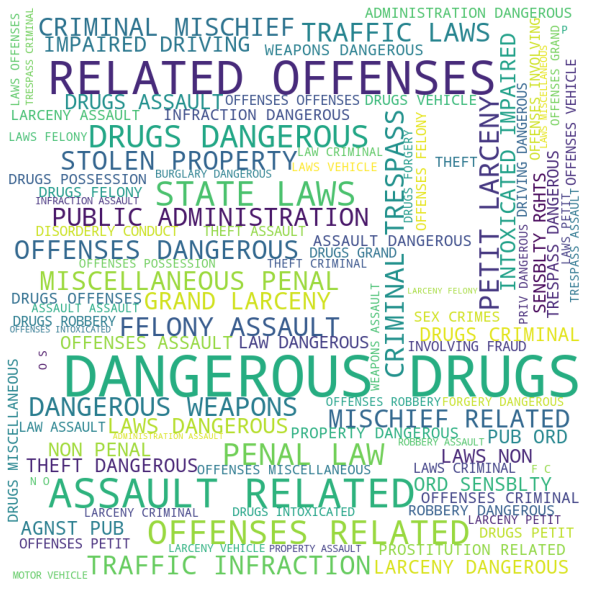

In [25]:
# Giant blob of wordcloud
plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [26]:
gavel = np.array(Image.open("gavel.png"))
gavel[gavel == 0] = 255

wc = WordCloud(background_color="black", max_words=100, mask=gavel,
               stopwords=stopwords, contour_width=3, colormap='Set2',contour_color='white')

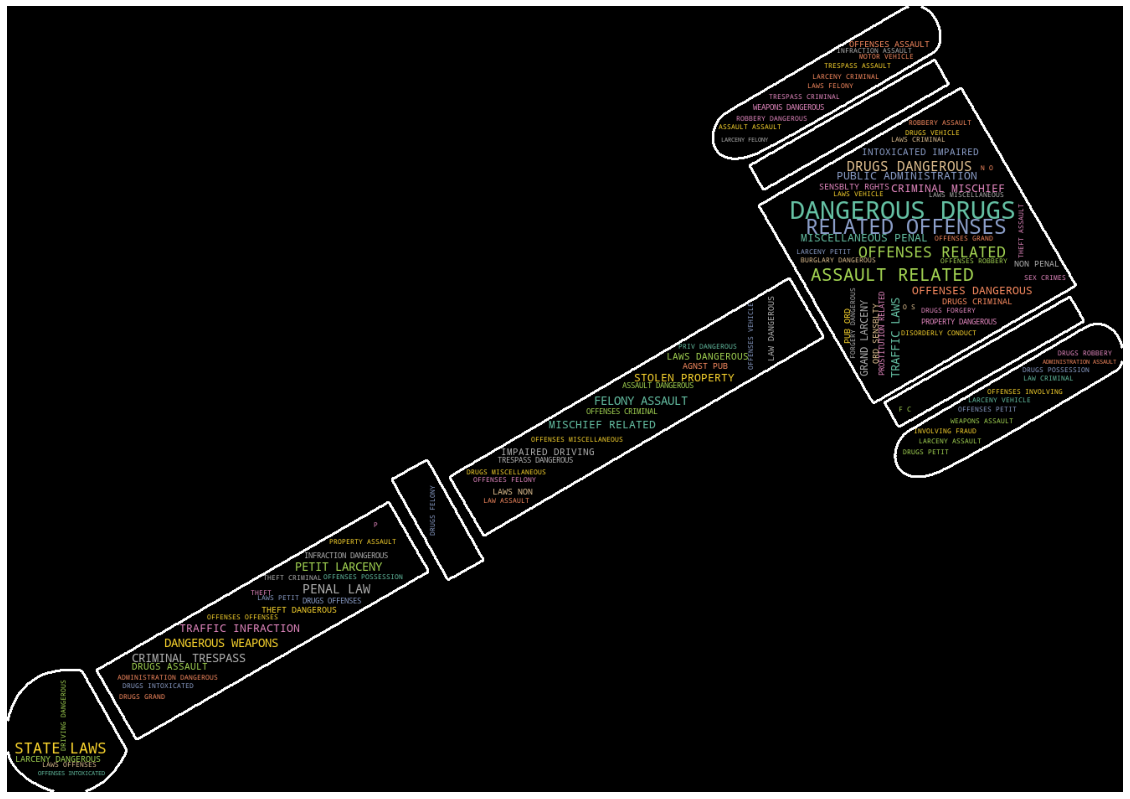

In [27]:
wc.generate(long_text)
wc.to_file("gavel_wc.png")
# show
plt.figure(figsize=[20,20])
plt.imshow(wc)
plt.axis("off")
plt.show()

# Top 5 Crimes for both Gender

In [121]:
df1=df[['arrest_key','ofns_desc','perp_sex']]

In [122]:
females = df1[df1['perp_sex']=='F']
males = df1[df1['perp_sex']=='M']

females.groupby(['perp_sex','ofns_desc']).count()['arrest_key'].nlargest(5)
males.groupby(['perp_sex','ofns_desc']).count()['arrest_key'].nlargest(5)

perp_sex  ofns_desc                      
M         DANGEROUS DRUGS                    721014
          ASSAULT 3 & RELATED OFFENSES       283361
          OTHER OFFENSES RELATED TO THEFT    207823
          OTHER STATE LAWS                   173885
          VEHICLE AND TRAFFIC LAWS           140057
Name: arrest_key, dtype: int64

In [123]:
male_crimes, male_crime_counts=[], []
female_crimes, female_crime_counts=[], []

for i,j in dict(males.groupby(['perp_sex','ofns_desc']).count()['arrest_key'].nlargest(5)).items():
    male_crimes.append(i[1])
    male_crime_counts.append(j)

for i,j in dict(females.groupby(['perp_sex','ofns_desc']).count()['arrest_key'].nlargest(5)).items():
    female_crimes.append(i[1])
    female_crime_counts.append(j)
    
    

In [124]:
fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Female', 'Male'])

fig.add_trace(go.Pie(labels=female_crimes,
                     values=female_crime_counts,
                     name="Female"), 1, 1)

fig.add_trace(go.Pie(labels=male_crimes, 
                     values=male_crime_counts,
                     name="Male"), 1, 2)



fig.update_layout(title_text='Top 5 crimes between for Female and Male')
fig.show()

#### Conclusions
- Both Female and Male commit heavy amount of crimes realted to drugs and Assault cases
- Female population commit more crime related to Felony Assault and Assault 3 & Related Offenses
- Male population commit more crime related to theft and, traffic laws.

# Relationship between race and level of offense in the past 5 years

In [127]:
df1=df[['arrest_key','perp_race','law_cat_cd','arrest_date']]

In [128]:
df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year

df1=df1[(df1['arrest_year']>2014) & (df1['perp_race']!='UNKNOWN')]

#remove nones from law_cat_cd
df1=df1.dropna() 

In [129]:
race=sorted(df1.perp_race.unique())
data_y=df1.groupby(['law_cat_cd','perp_race']).count()['arrest_key']
law_cat= sorted(df1.law_cat_cd.unique())

In [130]:
specs = [[{'type':'domain'}, {'type':'domain'}],
          [{'type':'domain'}, {'type':'domain'}]]

fig = make_subplots(rows=2, cols=2, 
                    specs=specs,
                    subplot_titles=['Felony', 'Infraction','Misdemeanor','Violation'])

fig.add_trace(go.Pie(labels=race, 
                     values=data_y[:6],
                     name="F"), 1, 1)

fig.add_trace(go.Pie(labels=race,
                     values=data_y[6:12], 
                     name="I"), 1, 2)

fig.add_trace(go.Pie(labels=race, 
                     values=data_y[12:18],
                     name="M"), 2, 1)

fig.add_trace(go.Pie(labels=race,
                     values=data_y[18:], 
                     name="V"), 2, 2)

fig.update_layout(title_text='Level Of Offense by Race',
                  margin=dict(b=0, l=0, r=0))
fig.show()

# Population Distribution

In [47]:
df1=df[['arrest_key','perp_race','arrest_date']]
df1=df1[(df1['perp_race']!='UNKNOWN')&(df1['perp_race']!='OTHER')]
df1['perp_race'].replace(['WHITE HISPANIC', 'BLACK HISPANIC','ASIAN / PACIFIC ISLANDER'],
                           ['HISPANIC','HISPANIC','ASIAN'],
                           inplace=True)


df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year

In [48]:
allin=[]

# new york population total
total = 8336817 
allin.append(total)

# each item represents % of a race in NYC.
# ex: - 24.3% of black race population as given by census
percentage=[.243,.291,.321,.141,.004]

for i in percentage:
    allin.append(int(round((total*i),0)))

for i in df1.perp_race.unique():
    df2=df1[df1['perp_race']==i]
    allin.append(df2.shape[0])

In [49]:
fig = go.Figure(go.Sunburst(
    labels=['Total Population',
            'Black', 'Hispanic', 'White', 'Asian', 'American Indian / <br> Alaskan Native',
           'Black Targeted','Hispanic Targeted','White Targeted','Asian Targeted','AI/AN Targeted'],
    parents=[''         ,
             'Total Population','Total Population','Total Population','Total Population','Total Population',
             'Black', 'Hispanic', 'White', 'Asian', 'American Indian / <br> Alaskan Native'],
    values=allin,
    branchvalues="total", 
    textinfo='label+value+percent parent'
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.show()

# Age

In [146]:
df1=df[['arrest_key','age_group','arrest_date']]

In [147]:
df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year
df1=df1[df1['arrest_year']>2014]

In [148]:
df1.groupby('age_group').count()['arrest_key'].nlargest()

age_group
25-44    538820
18-24    258851
45-64    210715
<18       62308
65+       11541
Name: arrest_key, dtype: int64

In [149]:
age_group=['18-24','25-44','45-64']

fig = go.Figure()

for i in age_group:
    age = df1[df1['age_group'] == i]
    
    fig.add_trace(go.Funnel(
        name = i,
        y = sorted(age.arrest_year.unique()),
        x = age.groupby('arrest_year').count()['arrest_key'],
        textinfo = "value+percent initial"))

fig.update_layout(
    title_text="Crime by Top Three Age Groups in the past 5 years")
print(df1.groupby('age_group').count()['arrest_key'].nlargest())
fig.show()

age_group
25-44    538820
18-24    258851
45-64    210715
<18       62308
65+       11541
Name: arrest_key, dtype: int64


#### Conclusions
- Age group 25-44 have committed the most crime, and age group 65+ have committed the least amount of crime.
- But as we saw earlier of how the crime rate is falling, we can see how the crime committed by this 3 age group is also declining. 
- The biggest change we see is for age group of 18-24, where the rate fell by 51%. We see changes in other two groups but its not as drastic change as the 18-24 age group. 
- Big Drop in crime count from years 2016-2017, could be because new Police Commissioner was assigned


## Age for months

In [180]:
df1['arrest_month'] = pd.DatetimeIndex(df1['arrest_date']).month
age1=df1[df1['age_group']=='<18']

In [181]:
months=['January','February','March','April','May','June',
        'July','August','September','October','November','December',]

In [183]:
age1['arrest_month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],
                           months,
                           inplace=True)


age1['arrest_month'] = pd.Categorical(age1['arrest_month'], months)


In [185]:
fig = go.Figure()

fig = go.Figure(go.Funnel(
    y = months,
    x = age1.groupby('arrest_month').count()['arrest_key'],
    textinfo = "value+percent initial"))

fig.update_layout(
    yaxis_title="Month Probability",
    title_text="Crime by <18 Age Groups in the past 5 years",
    height=750
)
fig.update_yaxes(tick0=1,dtick=1)

fig.show()


# Change in Number of Cases

For Drugs and Assault Related cases

In [222]:
df1 = df[['arrest_key','arrest_date','ofns_desc']]
df1 = df1[(df1['ofns_desc'] == 'DANGEROUS DRUGS')]
df1.reset_index(drop=True,inplace=True)

In [223]:
df1['arrest_year'] = pd.DatetimeIndex(df1['arrest_date']).year

In [224]:
x = list(df1.groupby(['arrest_year','ofns_desc'])['arrest_key'].count())

In [225]:
dli=[]

for i in range(1,len(x)):
    s=x[i]-x[i-1]
    dli.append(s)

# to leave gap on top and bottom for better visual
dli.insert(0,0)
dli.insert(len(drugs),0)

In [226]:
years=sorted(df1.arrest_year.unique())
years.insert(15,2020)


fig = go.Figure()
fig = go.Figure(go.Waterfall(
        orientation = "h",
        y = years,
        x = dli,
        textposition = "auto",
        text = dli,
        connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}}
    ))

fig.update_layout(
    xaxis1 = dict(
        title='Count'
    ),
    yaxis1 = dict(
        title='Years'
    ),
    title_text="Drugs vs. Assault Related Cases")

fig.show()

#### Conclusion
- Both of the crimes have been on the decline since 2014.
- Drugs related crimes has been declining at an alarming rate, it could be because people are seeing and understanding the benefits of some drugs, and it could be also that some laws related to drugs are being loosen.